In [94]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
import warnings
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb

In [95]:
data = pd.read_csv(r'C:\Users\karen\OneDrive\Escritorio\Especializacion\ML1\data\fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Me fijo si hay observaciones duplicadas
duplic = data.duplicated()
num_duplicates = duplic.sum()
print("Cantidad de filas duplicadas:", num_duplicates)

Cantidad de filas duplicadas: 0


In [96]:
# Eliminar columnas irrelevantes 
data = data.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

In [97]:
data.shape

(6362620, 8)

In [98]:
# Veo si hay missing values
data.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [99]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [100]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [101]:
# Separo tipos de variables para analizar

# Obtener los nombres de las columnas categóricas
cat_cols = data.select_dtypes(include='object').columns
print("Variables categóricas en el dataset:")
for col in cat_cols:
    print(col)

# Obtener los nombres de las columnas numéricas
num_cols = data.select_dtypes(include='number').columns
print("Variables numéricas en el dataset:")
for col in num_cols:
    print(col)

Variables categóricas en el dataset:
type
Variables numéricas en el dataset:
step
amount
oldbalanceOrg
newbalanceOrig
oldbalanceDest
newbalanceDest
isFraud


In [104]:
#isFraud es categórica
num_cols = num_cols.drop(["isFraud"])

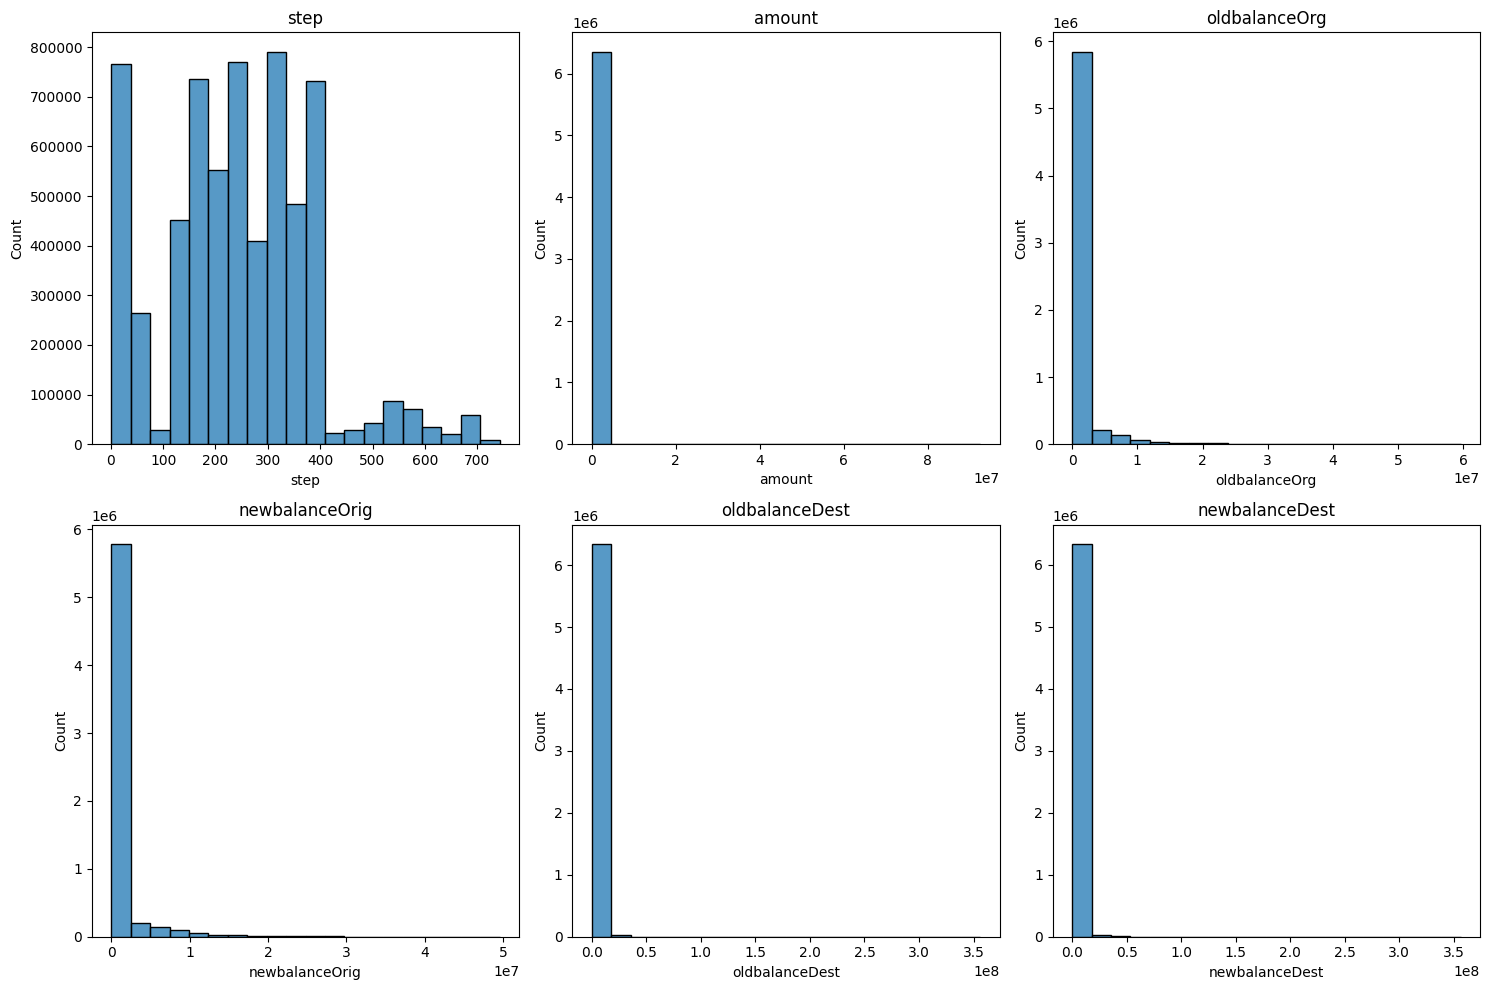

In [105]:
# Explorar las variables numéricas
if num_cols.any():
    num_col = 3
    num_row = -(-len(num_cols) // num_col)  # ceil division
    fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(15, 5*num_row))

    for i, col in enumerate(num_cols):
        row = i // num_col
        sns.histplot(data[col], ax=axs[row, i % num_col], bins=20)
        axs[row, i % num_col].set(title=col)

    plt.tight_layout()
    plt.savefig('histograms.png', dpi=300)
    plt.show()
else:
    print("No hay variables numéricas en los datos.")

In [106]:
# Verificar el balance de clases
fraud_count = data["isFraud"].sum()
non_fraud_count = len(data) - fraud_count
fraud_percentage = (fraud_count / len(data)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Transacciones fraudulentas: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Transacciones no fraudulentas: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Transacciones fraudulentas: 8213 (0.13%)
Transacciones no fraudulentas: 6354407 (99.87%)


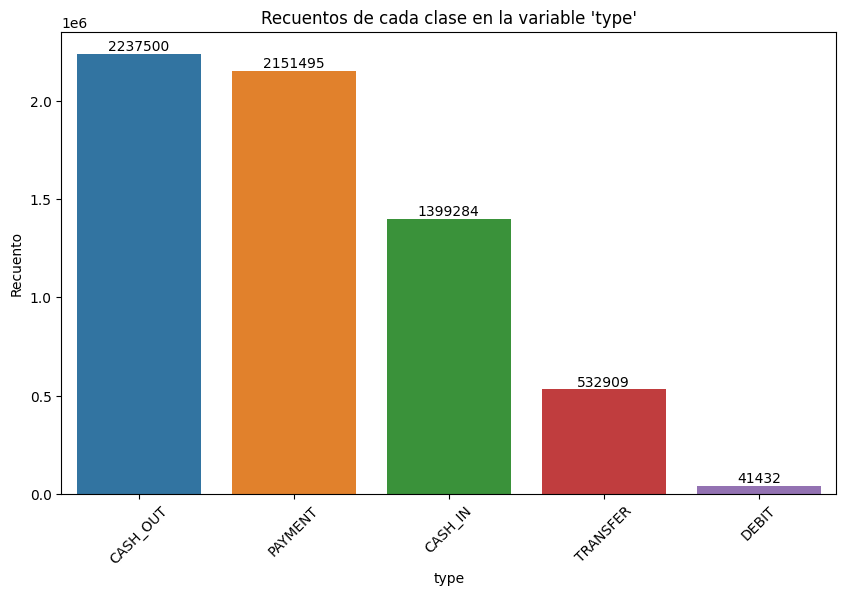

In [107]:
# Exploro los tipos de transacción

# Obtener los recuentos de cada clase
counts = data['type'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts.index, y=counts.values)
plt.title(f"Recuentos de cada clase en la variable '{'type'}'")
plt.xlabel('type')
plt.ylabel("Recuento")
plt.xticks(rotation=45)

# Agregar los valores en las barras
for i, count in enumerate(counts.values):
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.show()

In [108]:
# Calcular los recuentos de cada categoría y la cantidad de elementos fraudulentos y no fraudulentos
counts = data['type'].value_counts()
fraud_counts = data[data['isFraud'] == 1]['type'].value_counts()
non_fraud_counts = data[data['isFraud'] == 0]['type'].value_counts()

# Crear la tabla
tabla = pd.DataFrame({'Recuento total': counts, 'Recuento de fraudes': fraud_counts, 'Recuento de no fraudes': non_fraud_counts})
tabla.index.name = 'type'

print(tabla)

          Recuento total  Recuento de fraudes  Recuento de no fraudes
type                                                                 
CASH_IN          1399284                  NaN                 1399284
CASH_OUT         2237500               4116.0                 2233384
DEBIT              41432                  NaN                   41432
PAYMENT          2151495                  NaN                 2151495
TRANSFER          532909               4097.0                  528812


Sólo hay transacciones fraudulentas en CASH_OUT y TRANSFER

In [109]:
types = data['type'].unique()

for type_value in types:
    globals()[f"{type_value.lower()}_df"] = data[data['type'] == type_value].copy()
    globals()[f"{type_value.lower()}_df"].drop('type', axis=1, inplace=True)

In [110]:
transfer_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,181.00,181.00,0.0,0.00,0.00,1
19,1,215310.30,705.00,0.0,22425.00,0.00,0
24,1,311685.89,10835.00,0.0,6267.00,2719172.89,0
58,1,62610.80,79114.00,16503.2,517.00,8383.29,0
78,1,42712.39,10363.39,0.0,57901.66,24044.18,0


In [111]:
cash_out_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
3,1,181.00,181.00,0.0,21182.0,0.00,1
15,1,229133.94,15325.00,0.0,5083.0,51513.44,0
42,1,110414.71,26845.41,0.0,288800.0,2415.16,0
47,1,56953.90,1942.02,0.0,70253.0,64106.18,0
48,1,5346.89,0.00,0.0,652637.0,6453430.91,0


Para incorporar la optimización de las ganancias en el entrenamiento del modelo de clasificación, se puede usar Cost-Sensitive Learning. Esta técnica asigna pesos diferentes a las clases en función de su costo asociado, de modo que el modelo se enfoque en minimizar los errores costosos. El objetivo es ajustar el equilibrio entre la clase positiva (fraude) y la clase negativa (no fraude) para mejorar el rendimiento del modelo en la detección de la clase minoritaria (fraude) teniendo en cuenta determinada función de coste.

En este caso, se busca maximizar la ganancia esperada teniendo en cuenta que por cada transacción aprobada el porcentaje de ganancia es de un 20% y por cada fraude aprobado se pierde el 100% del dinero de la transacción. Para lograr esto, voy a definir manualmente diferentes pesos de clase, calcular la ganancia esperada para cada configuración de pesos de clase y seleccionar el modelo que obtenga la ganancia neta más alta. Este enfoque considera tanto el desequilibrio de clases como la ganancia esperada, lo que te permite evaluar y seleccionar el modelo que ofrece el mejor equilibrio entre la precisión en la detección de casos de fraude y la ganancia asociada a esos casos.

Es importante tener en cuenta que el ajuste de los pesos de clase es una de las estrategias para manejar el desequilibrio de clases, pero hay otras técnicas disponibles, como el submuestreo, el sobremuestreo, la generación sintética y el uso de algoritmos específicos para desequilibrio de clases. La elección de la técnica adecuada depende del problema específico y de las características de los datos.

Dado que sólo TRANSFER y CASH_OUT tienen transacciones fraudulentas, se empieza el ejercicio probando modelos para estos segmentos.

### Transfer

In [112]:
# Verificar el balance de clases
fraud_count = transfer_df["isFraud"].sum()
non_fraud_count = len(transfer_df) - fraud_count
fraud_percentage = (fraud_count / len(transfer_df)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Transacciones fraudulentas: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Transacciones no fraudulentas: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Transacciones fraudulentas: 4097 (0.77%)
Transacciones no fraudulentas: 528812 (99.23%)


In [113]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = transfer_df.drop('isFraud', axis=1)
y = transfer_df['isFraud']

In [114]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
3243756,250,3315876.61,5412.0,0.0,94702.35,3410578.96
4938043,350,1196860.54,57074.0,0.0,69766.62,1266627.15
5083950,355,261328.52,40006.0,0.0,0.00,261328.52
336698,16,466989.62,137.0,0.0,0.00,787420.08
1317264,136,487035.87,159111.0,0.0,0.00,487035.87


In [116]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)  # Estandarizamos los datos de entrenamiento
X_test_sc = scaler.transform(X_test)  # Aplicamos la misma transformación a los datos de prueba
X_test_df = pd.DataFrame(X_test_sc)
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.head()

,0,1,2,3,4,5
0,0.023845,1.286311,-0.112077,-0.040191,-0.411442,-0.018442
1,0.713620,0.153542,0.006025,-0.040191,-0.415603,-0.310889
2,0.748108,-0.346568,-0.032994,-0.040191,-0.427246,-0.448018
3,-1.590227,-0.236627,-0.124136,-0.040191,-0.427246,-0.376256
4,-0.762498,-0.225911,0.239285,-0.040191,-0.427246,-0.417230


#### Regresión logística

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.18
--------------------
Iteración: 3
Peso de clase: 1.37
--------------------
Iteración: 4
Peso de clase: 1.55
--------------------
Iteración: 5
Peso de clase: 1.73
--------------------
Iteración: 6
Peso de clase: 1.92
--------------------
Iteración: 7
Peso de clase: 2.1
--------------------
Iteración: 8
Peso de clase: 2.29
--------------------
Iteración: 9
Peso de clase: 2.47
--------------------
Iteración: 10
Peso de clase: 2.65
--------------------
Iteración: 11
Peso de clase: 2.84
--------------------
Iteración: 12
Peso de clase: 3.02
--------------------
Iteración: 13
Peso de clase: 3.2
--------------------
Iteración: 14
Peso de clase: 3.39
--------------------
Iteración: 15
Peso de clase: 3.57
--------------------
Iteración: 16
Peso de clase: 3.76
--------------------
Iteración: 17
Peso de clase: 3.94
--------------------
Iteración: 18
Peso de clase: 4.12
--------------------
Iteración: 19
Peso de 

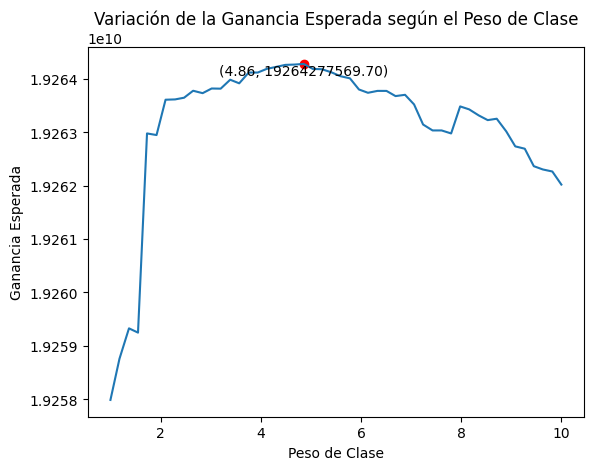

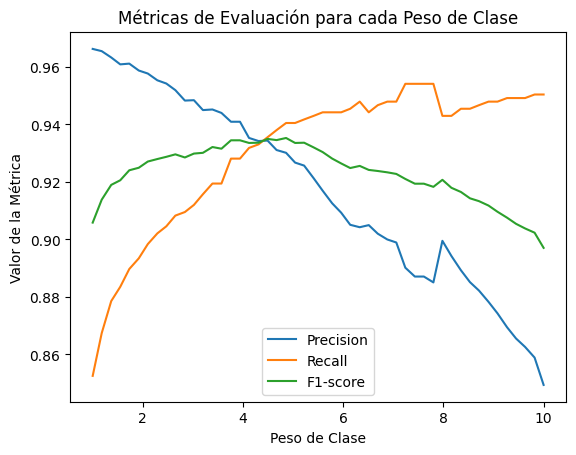

In [117]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# Probé primero con valores hasta el inverso del desequilibrio de clase, pero con pesos mayores a 10 la ganancia solo cae
# desbalance = 1/0.0077
# weights = np.linspace(1, desbalance, 30) 
weights = np.linspace(1, 10, 50) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

Pruebo usando pesos menores para la clase mayoritaria

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.03
--------------------
Iteración: 3
Peso de clase: 1.07
--------------------
Iteración: 4
Peso de clase: 1.1
--------------------
Iteración: 5
Peso de clase: 1.14
--------------------
Iteración: 6
Peso de clase: 1.17
--------------------
Iteración: 7
Peso de clase: 1.21
--------------------
Iteración: 8
Peso de clase: 1.24
--------------------
Iteración: 9
Peso de clase: 1.28
--------------------
Iteración: 10
Peso de clase: 1.31
--------------------
Iteración: 11
Peso de clase: 1.34
--------------------
Iteración: 12
Peso de clase: 1.38
--------------------
Iteración: 13
Peso de clase: 1.41
--------------------
Iteración: 14
Peso de clase: 1.45
--------------------
Iteración: 15
Peso de clase: 1.48
--------------------
Iteración: 16
Peso de clase: 1.52
--------------------
Iteración: 17
Peso de clase: 1.55
--------------------
Iteración: 18
Peso de clase: 1.59
--------------------
Iteración: 19
Peso de

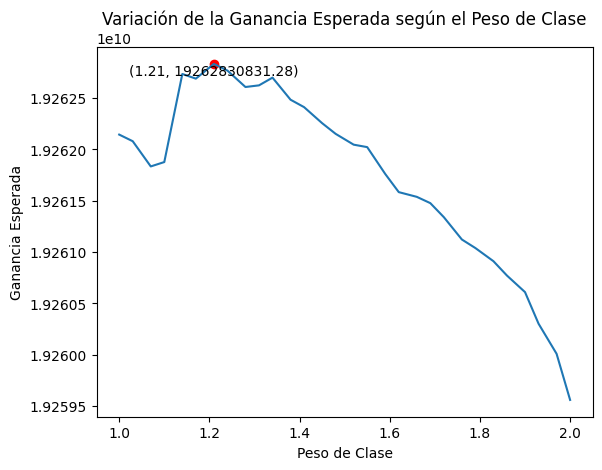

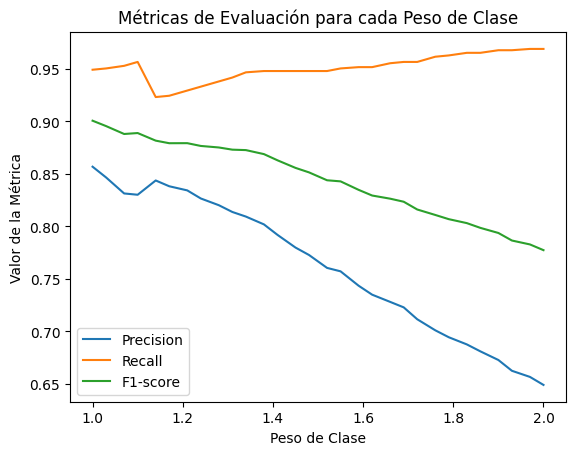

In [118]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
weights = np.linspace(1, 2, 30) 
weights = np.round(weights, decimals=2)
profits = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, se le asigna un peso de 0.1 a la clase no fraude
    class_weights = {0: 0.1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### Random forest

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 5.44
--------------------
Iteración: 3
Peso de clase: 9.89
--------------------
Iteración: 4
Peso de clase: 14.33
--------------------
Iteración: 5
Peso de clase: 18.78
--------------------
Iteración: 6
Peso de clase: 23.22
--------------------
Iteración: 7
Peso de clase: 27.66
--------------------
Iteración: 8
Peso de clase: 32.11
--------------------
Iteración: 9
Peso de clase: 36.55
--------------------
Iteración: 10
Peso de clase: 40.99
--------------------
Iteración: 11
Peso de clase: 45.44
--------------------
Iteración: 12
Peso de clase: 49.88
--------------------
Iteración: 13
Peso de clase: 54.33
--------------------
Iteración: 14
Peso de clase: 58.77
--------------------
Iteración: 15
Peso de clase: 63.21
--------------------
Iteración: 16
Peso de clase: 67.66
--------------------
Iteración: 17
Peso de clase: 72.1
--------------------
Iteración: 18
Peso de clase: 76.54
--------------------
Iterac

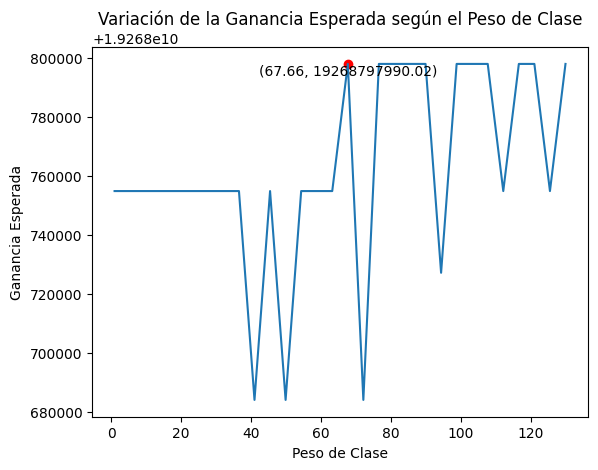

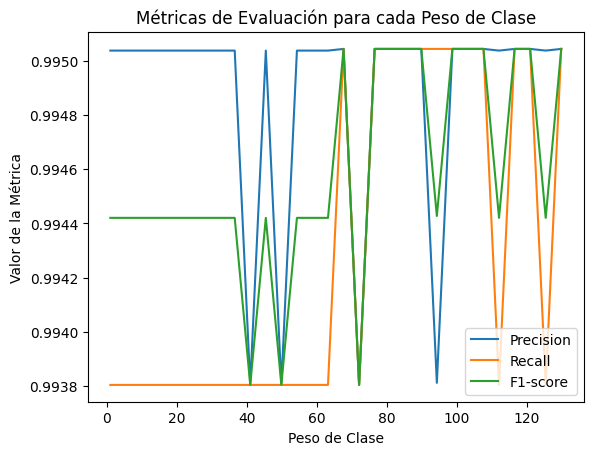

In [119]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
desbalance = 1/0.0077
weights = np.linspace(1, desbalance, 30) 
# weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### XGBoost

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 5.44
--------------------
Iteración: 3
Peso de clase: 9.89
--------------------
Iteración: 4
Peso de clase: 14.33
--------------------
Iteración: 5
Peso de clase: 18.78
--------------------
Iteración: 6
Peso de clase: 23.22
--------------------
Iteración: 7
Peso de clase: 27.66
--------------------
Iteración: 8
Peso de clase: 32.11
--------------------
Iteración: 9
Peso de clase: 36.55
--------------------
Iteración: 10
Peso de clase: 40.99
--------------------
Iteración: 11
Peso de clase: 45.44
--------------------
Iteración: 12
Peso de clase: 49.88
--------------------
Iteración: 13
Peso de clase: 54.33
--------------------
Iteración: 14
Peso de clase: 58.77
--------------------
Iteración: 15
Peso de clase: 63.21
--------------------
Iteración: 16
Peso de clase: 67.66
--------------------
Iteración: 17
Peso de clase: 72.1
--------------------
Iteración: 18
Peso de clase: 76.54
--------------------
Iterac

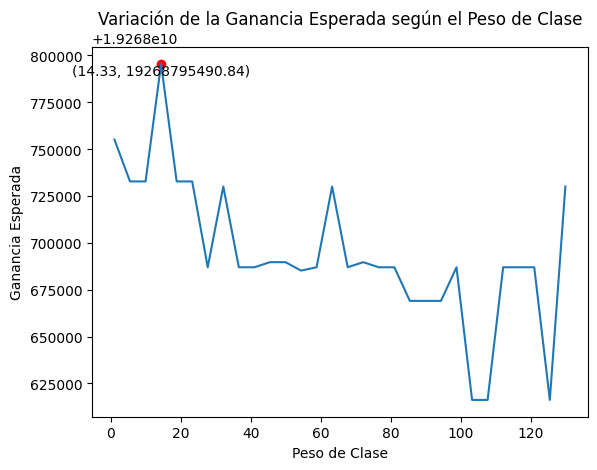

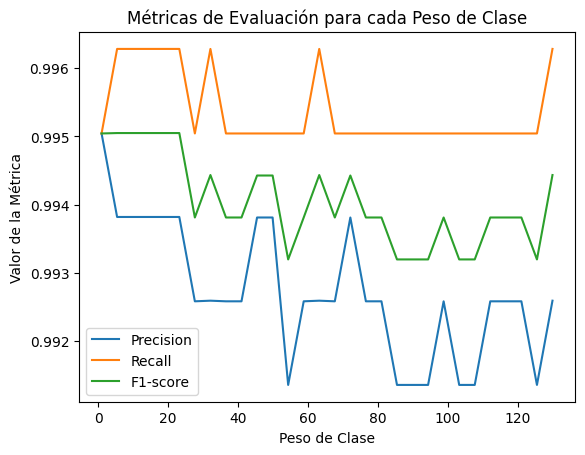

In [121]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
desbalance = 1/0.0077
weights = np.linspace(1, desbalance, 30) 
# weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = xgb.XGBClassifier(random_state=42, scale_pos_weight=weight)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

### Comparación de modelos

In [149]:
# Defino funcion de lineas que se van a repetir varias veces
def compare():
    # Predicciones y métricas
    models = ['Logistic Regression', 'Random Forest', 'XGBoost']
    metrics = ['Recall', 'Precision', 'F1-Score', 'Accuracy', 'AUPRC', 'Profit']

    # Predicciones
    lr_preds = lr_model.predict(X_test_sc)
    rf_preds = rf_model.predict(X_test_sc)
    xgb_preds = xgb_model.predict(X_test_sc)

    # Crear un diccionario para mapear los nombres de los modelos con las predicciones
    model_preds = {
        'Logistic Regression': lr_preds,
        'Random Forest': rf_preds,
        'XGBoost': xgb_preds}

    # Crear un Dataframe para almacenar los resultados de las métricas
    results = pd.DataFrame(index=model_preds.keys(), columns=metrics)
    # Calcular las métricas para cada modelo
    for model, preds in model_preds.items():
        results.loc[model, 'Recall'] = recall_score(y_test, preds)
        results.loc[model, 'Precision'] = precision_score(y_test, preds)
        results.loc[model, 'F1-Score'] = f1_score(y_test, preds)
        results.loc[model, 'Accuracy'] = accuracy_score(y_test, preds)
        results.loc[model, 'AUPRC'] = average_precision_score(y_test, preds)

    # Calcular la ganancia neta para cada modelo
    pred = X_test.copy()
    pred['y_test'] = y_test
    pred['pred_Logistic Regression'] = lr_preds
    pred['pred_Random Forest'] = rf_preds
    pred['pred_XGBoost'] = xgb_preds

    for model, preds in model_preds.items():
        pred['TN_' + str(model)] = np.where((pred['pred_'+ str(model)] == 0) & (pred['y_test'] == 0), 1, 0)
        pred['FN_' + str(model)] = np.where((pred['pred_'+ str(model)] == 0) & (pred['y_test'] == 1), 1, 0)
        results.loc[model, 'Profit'] = (0.2 * pred.loc[pred['TN_'+ str(model)] == 1, 'amount'].sum()) - pred.loc[pred['FN_'+ str(model)] == 1, 'amount'].sum()

    return results

In [152]:
# Modelos y pesos de clase con mayor ganancia neta
peso_opt_lr = 4.86
peso_opt_rf = 67.66
peso_opt_xgb = 14.33

# Regresión Logística
lr_model = LogisticRegressionCV(random_state=42, class_weight={0: 1, 1: peso_opt_lr}, max_iter=100)
lr_model.fit(X_train_sc, y_train)
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: peso_opt_rf})
rf_model.fit(X_train_sc, y_train)
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=peso_opt_xgb)
xgb_model.fit(X_train_sc, y_train)

compare()

,Recall,Precision,F1-Score,Accuracy,AUPRC,Profit
Logistic Regression,0.94052,0.930147,0.935305,0.999015,0.875273,19264277569.698002
Random Forest,0.995043,0.995043,0.995043,0.999925,0.990149,19268797990.021999
XGBoost,0.996283,0.99382,0.99505,0.999925,0.990153,19268795490.838001


#### Modelo final para TRANSFER

El modelo con mejor ganancia neta fue un Random Forest con class_weights = {0: 1, 1: 67.66} 

In [153]:
def evaluar(y_test, y_train, y_pred, y_pred_is):

    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('AUC-ROC:', roc_auc_score(y_test, y_pred))
    print(classification_report(y_test,y_pred))

    cm = confusion_matrix(y_train, y_pred_is)
    sns.heatmap(cm, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de confusion - train data')
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de confusion - test data')
    plt.show()

Accuracy: 0.999915557974142
Precision: 0.9925925925925926
Recall: 0.9962825278810409
F1: 0.9944341372912802
AUC-ROC: 0.99811290185118
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105775
           1       0.99      1.00      0.99       807

    accuracy                           1.00    106582
   macro avg       1.00      1.00      1.00    106582
weighted avg       1.00      1.00      1.00    106582



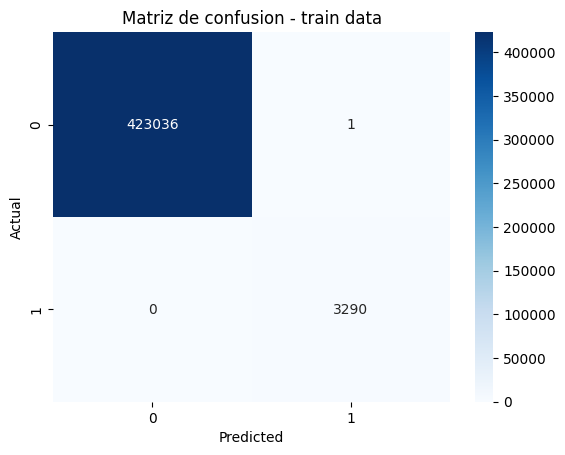

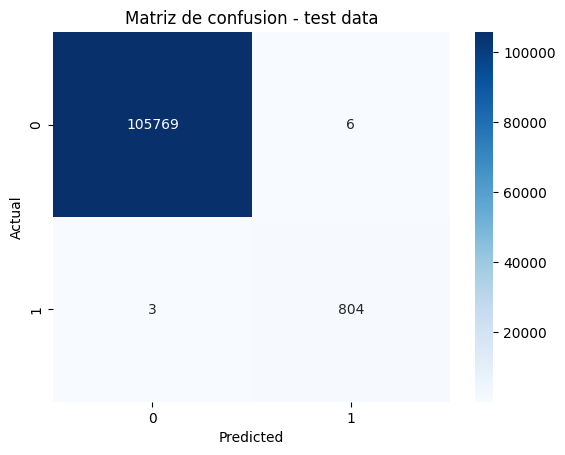

In [154]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: 67.66})
rf_model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)
y_pred_is = model.predict(X_train_sc)

# Métricas de evaluación
evaluar(y_test, y_train, y_pred, y_pred_is)

#### Cash_out

In [173]:
# Verificar el balance de clases
fraud_count = cash_out_df["isFraud"].sum()
non_fraud_count = len(cash_out_df) - fraud_count
fraud_percentage = (fraud_count / len(cash_out_df)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Transacciones fraudulentas: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Transacciones no fraudulentas: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Transacciones fraudulentas: 4116 (0.18%)
Transacciones no fraudulentas: 2233384 (99.82%)


In [174]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = cash_out_df.drop('isFraud', axis=1)
y = cash_out_df['isFraud']

In [175]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
# Verificar el balance de clases en train set
fraud_count = y_train.sum()
non_fraud_count = len(y_train) - fraud_count
fraud_percentage = (fraud_count / len(y_train)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Fraudulent transactions: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Non-fraudulent transactions: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Fraudulent transactions: 3279 (0.18%)
Non-fraudulent transactions: 1786721 (99.82%)


In [177]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2886605,228,280552.81,204968.33,0.00,1432809.08,1713361.89
4856563,347,460820.30,54980.00,0.00,55726.68,516546.98
1776745,162,79118.36,70297.00,0.00,98344.79,177463.15
4608151,329,136339.64,0.00,0.00,6420331.26,6556670.90
1472786,141,53092.84,366067.00,312974.16,85463.30,138556.14


In [178]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)  # Estandarizamos los datos de entrenamiento
X_test_sc = scaler.transform(X_test)  # Aplicamos la misma transformación a los datos de prueba
X_test_df = pd.DataFrame(X_test_sc)
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.head()

,0,1,2,3,4,5
0,-0.091756,0.593723,0.882097,-0.158226,-0.017550,0.006359
1,0.753389,1.619781,0.049769,-0.158226,-0.396758,-0.320487
2,-0.560492,-0.552813,0.134767,-0.158226,-0.385022,-0.413090
3,0.625552,-0.227118,-0.255331,-0.158226,1.355866,1.329053
4,-0.709636,-0.700947,1.776079,2.675079,-0.388569,-0.423715


#### Regresión logística

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.47
--------------------
Iteración: 3
Peso de clase: 1.95
--------------------
Iteración: 4
Peso de clase: 2.42
--------------------
Iteración: 5
Peso de clase: 2.89
--------------------
Iteración: 6
Peso de clase: 3.37
--------------------
Iteración: 7
Peso de clase: 3.84
--------------------
Iteración: 8
Peso de clase: 4.32
--------------------
Iteración: 9
Peso de clase: 4.79
--------------------
Iteración: 10
Peso de clase: 5.26
--------------------
Iteración: 11
Peso de clase: 5.74
--------------------
Iteración: 12
Peso de clase: 6.21
--------------------
Iteración: 13
Peso de clase: 6.68
--------------------
Iteración: 14
Peso de clase: 7.16
--------------------
Iteración: 15
Peso de clase: 7.63
--------------------
Iteración: 16
Peso de clase: 8.11
--------------------
Iteración: 17
Peso de clase: 8.58
--------------------
Iteración: 18
Peso de clase: 9.05
--------------------
Iteración: 19
Peso d

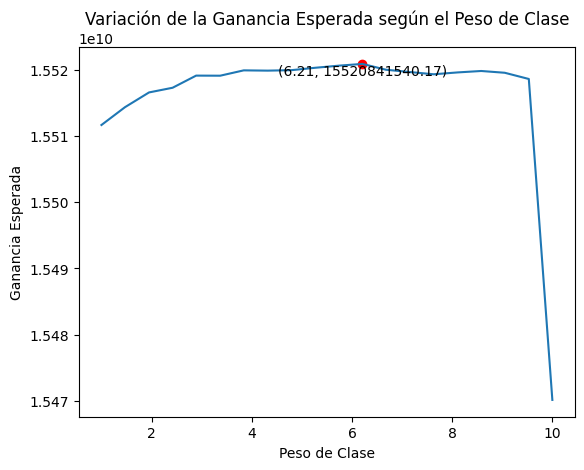

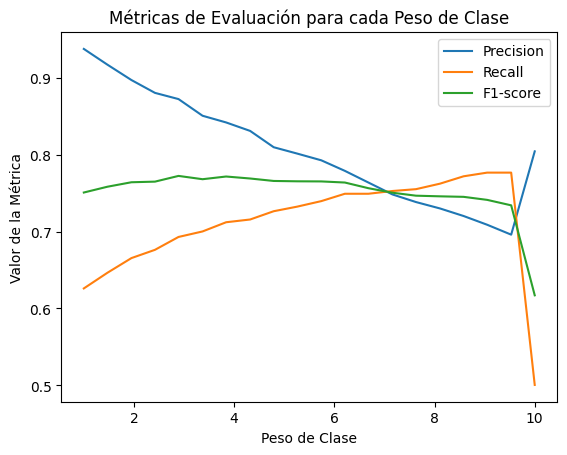

In [161]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# Probé primero con valores hasta el inverso del desequilibrio de clase, pero con pesos mayores a 10 la ganancia solo cae
# desbalance = 1/0.0018
# weights = np.linspace(1, desbalance, 5) 
weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### Random Forest

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.66
--------------------
Iteración: 3
Peso de clase: 2.31
--------------------
Iteración: 4
Peso de clase: 2.97
--------------------
Iteración: 5
Peso de clase: 3.62
--------------------
Iteración: 6
Peso de clase: 4.28
--------------------
Iteración: 7
Peso de clase: 4.93
--------------------
Iteración: 8
Peso de clase: 5.59
--------------------
Iteración: 9
Peso de clase: 6.24
--------------------
Iteración: 10
Peso de clase: 6.9
--------------------
Iteración: 11
Peso de clase: 7.55
--------------------
Iteración: 12
Peso de clase: 8.21
--------------------
Iteración: 13
Peso de clase: 8.86
--------------------
Iteración: 14
Peso de clase: 9.52
--------------------
Iteración: 15
Peso de clase: 10.17
--------------------
Iteración: 16
Peso de clase: 10.83
--------------------
Iteración: 17
Peso de clase: 11.48
--------------------
Iteración: 18
Peso de clase: 12.14
--------------------
Iteración: 19
Pes

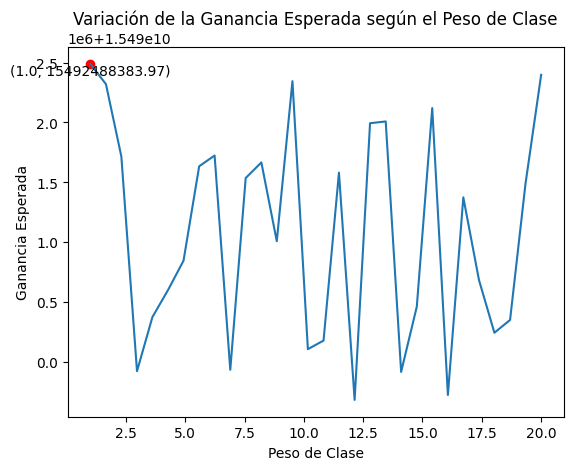

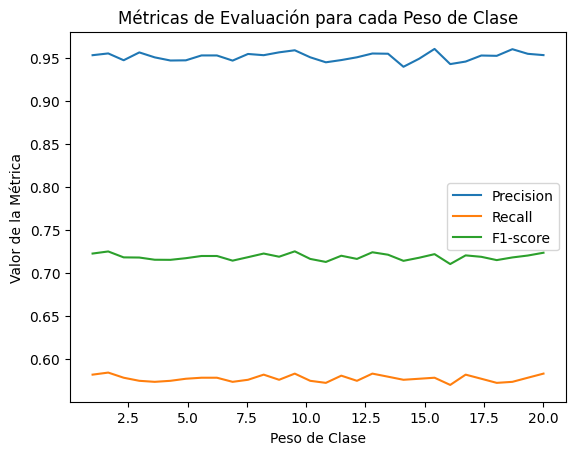

In [164]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# desbalance = 1/0.0018
# weights = np.linspace(1, desbalance, 20) 
weights = np.linspace(1, 20, 30) 
weights = np.round(weights, decimals=2)
profits = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### XGBoost

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 2.69
--------------------
Iteración: 3
Peso de clase: 4.38
--------------------
Iteración: 4
Peso de clase: 6.07
--------------------
Iteración: 5
Peso de clase: 7.76
--------------------
Iteración: 6
Peso de clase: 9.45
--------------------
Iteración: 7
Peso de clase: 11.14
--------------------
Iteración: 8
Peso de clase: 12.83
--------------------
Iteración: 9
Peso de clase: 14.52
--------------------
Iteración: 10
Peso de clase: 16.21
--------------------
Iteración: 11
Peso de clase: 17.9
--------------------
Iteración: 12
Peso de clase: 19.59
--------------------
Iteración: 13
Peso de clase: 21.28
--------------------
Iteración: 14
Peso de clase: 22.97
--------------------
Iteración: 15
Peso de clase: 24.66
--------------------
Iteración: 16
Peso de clase: 26.34
--------------------
Iteración: 17
Peso de clase: 28.03
--------------------
Iteración: 18
Peso de clase: 29.72
--------------------
Iteración

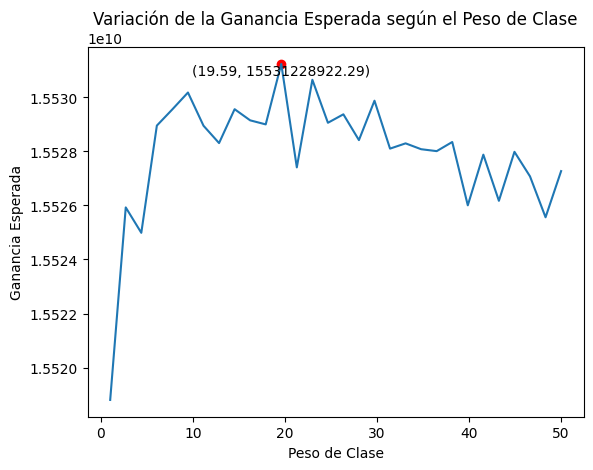

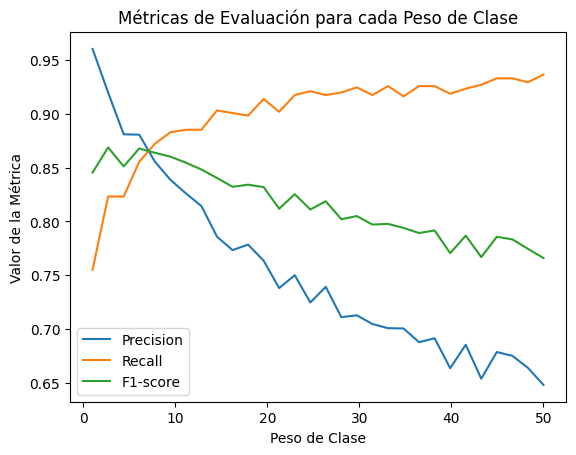

In [165]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# Probé primero con valores hasta el inverso del desequilibrio de clase, pero con pesos mayores a 10 la ganancia solo cae
# desbalance = 1/0.0018
# weights = np.linspace(1, desbalance, 30) 
weights = np.linspace(1, 50, 30) 
weights = np.round(weights, decimals=2)
profits = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = xgb.XGBClassifier(random_state=42, scale_pos_weight=weight)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

### Comparación de modelos

In [179]:
# Modelos y pesos de clase con mayor ganancia neta
peso_opt_lr = 6.21
peso_opt_rf = 1
peso_opt_xgb = 19.59

# Regresión Logística
lr_model = LogisticRegressionCV(random_state=42, class_weight={0: 1, 1: peso_opt_lr}, max_iter=100)
lr_model.fit(X_train_sc, y_train)
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: peso_opt_rf})
rf_model.fit(X_train_sc, y_train)
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=peso_opt_xgb)
xgb_model.fit(X_train_sc, y_train)

compare()

,Recall,Precision,F1-Score,Accuracy,AUPRC,Profit
Logistic Regression,0.749104,0.778882,0.763703,0.999133,0.583933,15520841540.172005
Random Forest,0.58184,0.953033,0.722552,0.999164,0.555295,15492488383.966007
XGBoost,0.913978,0.763473,0.831974,0.999309,0.697959,15531228922.287994


##### Modelo final para CASH_OUT

El modelo con mejor ganancia esperada fue un XGBoost con class_weights = {0: 1, 1: 19.59} 

Accuracy: 0.9993251396648045
Precision: 0.7737973387922211
Recall: 0.9032258064516129
F1: 0.8335170893054025
AUC-ROC: 0.9513655131352908
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446663
           1       0.77      0.90      0.83       837

    accuracy                           1.00    447500
   macro avg       0.89      0.95      0.92    447500
weighted avg       1.00      1.00      1.00    447500



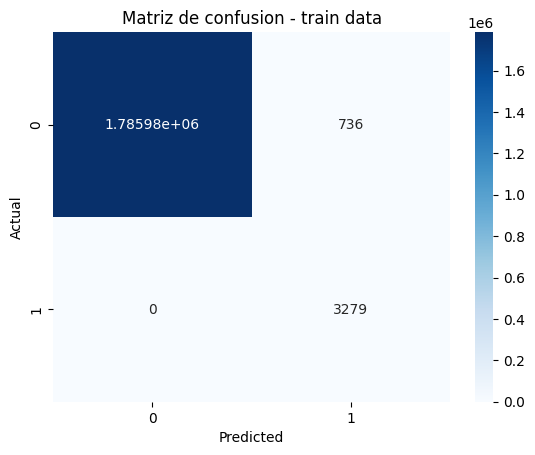

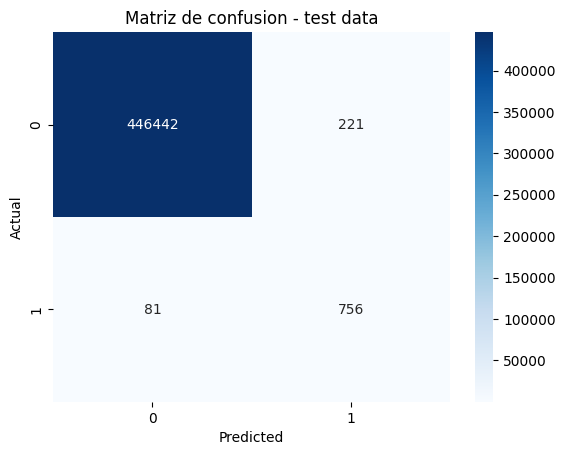

In [56]:
model = xgb.XGBClassifier(random_state=42, scale_pos_weight=20.12)
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)
y_pred_is = model.predict(X_train_sc)

# Métricas de evaluación
evaluar(y_test, y_train, y_pred, y_pred_is)

### Modelo con el dataset entero

Dado que pueden ocurrir transacciones fraudulentas dentro de los tipos de transacción que no son TRANSFER ni CASH_OUT, a continuación se van a probar distintos pesos de clase usando el dataset entero. Luego, se comparan las predicciones del modelo final obtenido con la data entera con las predicciones obtenidas para el total del dataset usando los modelos anteriormente obtenidos para los segmentos TRANSFER y CASH_OUT.

In [166]:
encoder = LabelEncoder()
data['type'] = encoder.fit_transform(data['type']) + 1

In [167]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = data.drop('isFraud', axis=1)
y = data['isFraud']

In [168]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
X_train.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
6271196,619,1,386385.08,4669568.85,5055953.92,506035.06,119649.98
1888243,164,1,212458.78,234635.00,447093.78,806037.88,593579.10
5549957,382,4,19967.60,3634.00,0.00,0.00,0.00
2025342,180,2,527616.51,180216.00,0.00,92157.10,619773.61
682342,36,5,206067.85,0.00,0.00,2131494.48,2337562.32


In [170]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)  # Estandarizamos los datos de entrenamiento
X_test_sc = scaler.transform(X_test)  # Aplicamos la misma transformación a los datos de prueba
X_test_df = pd.DataFrame(X_test_sc)
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.head()

,0,1,2,3,4,5,6
0,2.639149,-1.269621,0.343453,1.328802,1.437536,-0.174992,-0.301147
1,-0.557841,-1.269621,0.054355,-0.207401,-0.139419,-0.086546,-0.171883
2,0.973904,0.952490,-0.265601,-0.287416,-0.292395,-0.324181,-0.333782
3,-0.445420,-0.528918,0.578206,-0.226251,-0.292395,-0.297011,-0.164739
4,-1.457215,1.693193,0.043732,-0.288675,-0.292395,0.304224,0.303786


#### Regresión logística

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.18
--------------------
Iteración: 3
Peso de clase: 1.37
--------------------
Iteración: 4
Peso de clase: 1.55
--------------------
Iteración: 5
Peso de clase: 1.73
--------------------
Iteración: 6
Peso de clase: 1.92
--------------------
Iteración: 7
Peso de clase: 2.1
--------------------
Iteración: 8
Peso de clase: 2.29
--------------------
Iteración: 9
Peso de clase: 2.47
--------------------
Iteración: 10
Peso de clase: 2.65
--------------------
Iteración: 11
Peso de clase: 2.84
--------------------
Iteración: 12
Peso de clase: 3.02
--------------------
Iteración: 13
Peso de clase: 3.2
--------------------
Iteración: 14
Peso de clase: 3.39
--------------------
Iteración: 15
Peso de clase: 3.57
--------------------
Iteración: 16
Peso de clase: 3.76
--------------------
Iteración: 17
Peso de clase: 3.94
--------------------
Iteración: 18
Peso de clase: 4.12
--------------------
Iteración: 19
Peso de 

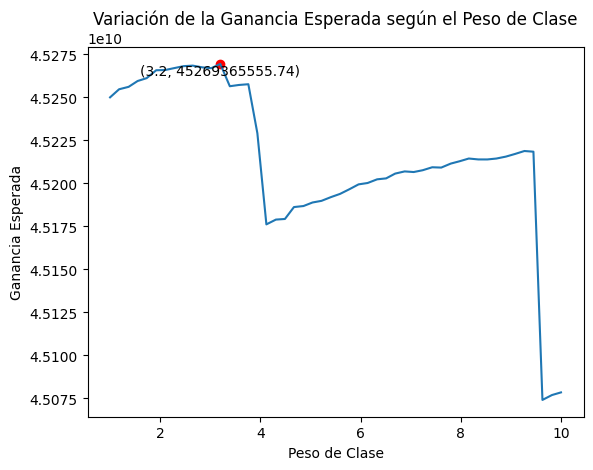

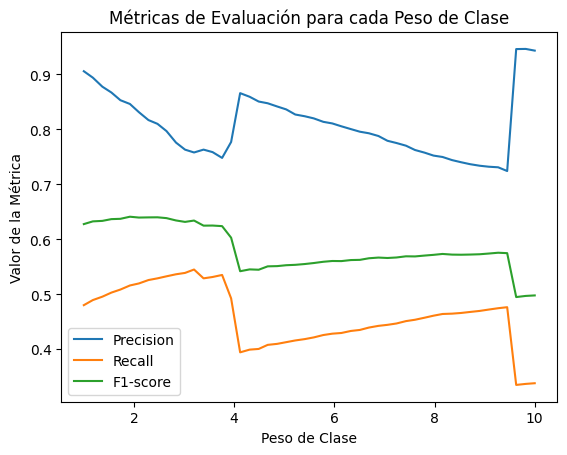

In [171]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# Probé primero con valores hasta el inverso del desequilibrio de clase, pero con pesos mayores a 10 la ganancia solo cae
# desbalance = 1/0.0013
# weights = np.linspace(1, desbalance, 30) 
weights = np.linspace(1, 10, 50) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### Random Forest

In [172]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# desbalance = 1/0.0013
# weights = np.linspace(1, desbalance, 20) 
weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

Iteración: 1
Peso de clase: 1.0
--------------------


KeyboardInterrupt: 

#### XGBoost

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 30.19
--------------------
Iteración: 3
Peso de clase: 59.37
--------------------
Iteración: 4
Peso de clase: 88.56
--------------------
Iteración: 5
Peso de clase: 117.75
--------------------
Iteración: 6
Peso de clase: 146.94
--------------------
Iteración: 7
Peso de clase: 176.12
--------------------
Iteración: 8
Peso de clase: 205.31
--------------------
Iteración: 9
Peso de clase: 234.5
--------------------
Iteración: 10
Peso de clase: 263.68
--------------------
Iteración: 11
Peso de clase: 292.87
--------------------
Iteración: 12
Peso de clase: 322.06
--------------------
Iteración: 13
Peso de clase: 351.25
--------------------
Iteración: 14
Peso de clase: 380.43
--------------------
Iteración: 15
Peso de clase: 409.62
--------------------
Iteración: 16
Peso de clase: 438.81
--------------------
Iteración: 17
Peso de clase: 467.99
--------------------
Iteración: 18
Peso de clase: 497.18
-----------

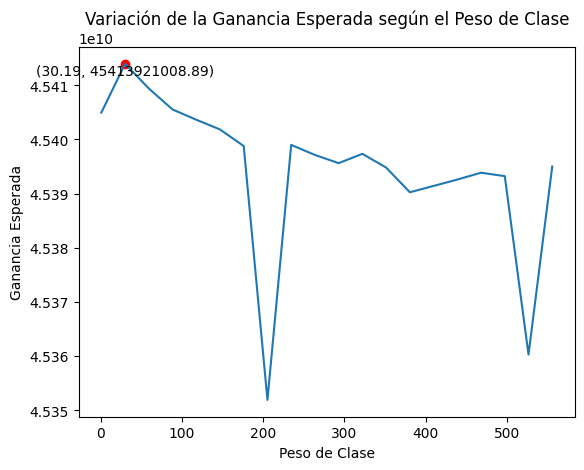

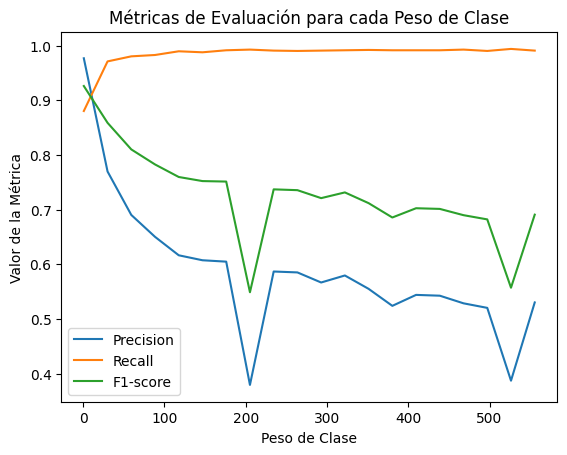

In [ ]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# Probé primero con valores hasta el inverso del desequilibrio de clase, pero con pesos mayores a 50 la ganancia solo cae
# desbalance = 1/0.0018
# weights = np.linspace(1, desbalance, 20) 
weights = np.linspace(1, 50, 20) 
weights = np.round(weights, decimals=2)
profits = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = xgb.XGBClassifier(random_state=42, scale_pos_weight=weight)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### Modelo final con el dataset entero

El modelo con mejor ganancia esperada fue un XGBoost con class_weights = {0: 1, 1: 20.12} 

In [ ]:
model = xgb.XGBClassifier(random_state=42, scale_pos_weight=20.12)
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)
y_pred_is = model.predict(X_train_sc)

# Métricas de evaluación
evaluar(y_test, y_train, y_pred, y_pred_is)

### Predicciones del dataset entero usando el modelo final entrenado para TRANSFER

In [ ]:
# Hago una copia de los features del dataset entero
X_train_full = X_train_sc.copy()
X_test_full = X_test_sc.copy()

In [ ]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = transfer_df.drop('isFraud', axis=1)
y = transfer_df['isFraud']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)  # Estandarizamos los datos de entrenamiento
X_test_sc = scaler.transform(X_test)  # Aplicamos la misma transformación a los datos de prueba
X_test_df = pd.DataFrame(X_test_sc)
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.head()

In [ ]:
model = xgb.XGBClassifier(random_state=42, scale_pos_weight=11.52)
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_full)
y_pred_is = model.predict(X_train_full)

# Métricas de evaluación
evaluar(y_test, y_train, y_pred, y_pred_is)

### Predicciones del dataset entero usando el modelo final entrenado para CASH_OUT

In [ ]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = cash_out_df.drop('isFraud', axis=1)
y = cash_out_df['isFraud']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)  # Estandarizamos los datos de entrenamiento
X_test_sc = scaler.transform(X_test)  # Aplicamos la misma transformación a los datos de prueba
X_test_df = pd.DataFrame(X_test_sc)
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.head()

In [ ]:
model = xgb.XGBClassifier(random_state=42, scale_pos_weight=20.12)
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_full)
y_pred_is = model.predict(X_train_full)

# Métricas de evaluación
evaluar(y_test, y_train, y_pred, y_pred_is)

## Conclusiones

Los modelos entrenados solo para transfer y solo para cash out tienen mejor performance y corren mas rapido, pero se corre el riesgo de no ver fraude en otros tipos de transaccion

O

Los modelos entrenados solo con transfer y solo con cash out entrenan mas rapido y tienen mejor performance en predecir fraude incluso en tipos de transaccion distintos.